## Лабораторная работа 3 - Байесовская оптимизация

## Построение регрессии с помощью Гауссовского процесса

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sb

### Генерация выборки

Ответ на очередном объекте $x_i$ генерируется следующим образом:

$$t_i = f(x_i)+\varepsilon_i, \; \varepsilon_i \sim \mathcal{N}(0,\sqrt{2})$$

In [3]:
def f(x):
    return -8*np.sin(x)

support = np.arange(-1.0, 11.0, 1e-2)

In [4]:
X_train = np.arange(0,10.0,0.5)
X_train = X_train.reshape([len(X_train), -1])
Y_train = f(X_train)
T_train = Y_train+2*np.random.randn(*X_train.shape)

X_test = support
X_test = X_test.reshape([len(X_test), -1])

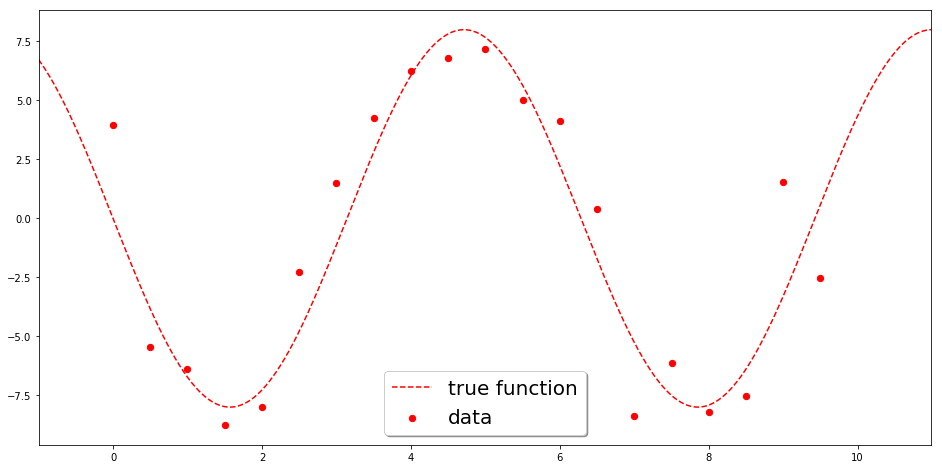

In [5]:
figsize(16,8)
plt.scatter(X_train.flatten(), T_train.flatten(), label='data', c='r', s=40)
plt.plot(support, f(support), '--r', label='true function')
plt.legend(fontsize=20, frameon=True, shadow=True)
plt.xlim(np.min(support), np.max(support))
plt.show()

### Предсказание

В тестовой точке $x$ мы можем предсказать два параметра – мат. ожидание $\mu(x)$ и стандартное отклонение $\sigma(x)$.
Для заданной ковариационной функции $k(x,y)$ и для заданной дисперсии случайного шума $\beta^{-1}$, $\mu(x), \sigma(x)$ вычисляются по следующим формулам:

$$\mu(x) = \mathbf{k}^T(x)C_N^{-1}\mathbf{t}, \;\;\;\; \sigma^2(x) = k(x,x)+\beta^{-1}-\mathbf{k}^T(x)C_N^{-1}\mathbf{k}(x),$$

где $\mathbf{k} = k(x_i, x)$ – вектор, состоящий из элементов $k(x_i, x), \; i=1,\ldots,N$,  
$\mathbf{t} = (t_1,\ldots,t_N)$ – вектор ответов на обучающей выборке,  
$С_N = \mathbf{K} + \beta^{-1}E$, где $\mathbf{K}_{ij} = k(x_i,x_j)$ – ковариационная матрица.

Примеры ковариационных функций:
- $K(x,y) = C$ – константная,
- $K(x,y) = \langle x,y \rangle$ – линейная,
- $K(x,y) = \exp(-\sum_{j=1}^d\theta_j(x_j-y_j)^2)$  – экспоненциальная,
- $K(x,y) = \exp(-\sum_{j=1}^d\theta_j|x_j-y_j|)$ – процесс Орнштейна-Уленбека.

**1.** Реализуте функции вычисления ковариационных матриц между двумя произвольными выборками объектов, а затем функцию, вычисляющую предсказание в новой точке. Циклы использовать запрещено.

In [6]:
def linear_k(X, Y, theta):
    return (X[:,None,:] * Y[None,:,:] * theta[None,None,:]).sum(axis=2)
    
def rbf_k(X, Y, theta):
    return np.exp(-(theta[None,None,:] * (X[:,None,:] - Y[None,:,:]) ** 2).sum(axis=2))

def ou_k(X, Y, theta):
    return np.exp(-(theta[None,None,:] * np.abs(X[:,None,:] - Y[None,:,:])).sum(axis=2))

def predict(X_train, T_train, X_test, theta, beta, kernel):
    K_train_test = kernel(X_train, X_test, theta)
    K_train_train = kernel(X_train, X_train, theta)
    K_test_test = kernel(X_test, X_test, theta)
    C_N_inv = np.linalg.inv(K_train_train + np.eye(X_train.shape[0]) / beta)
    K_C = K_train_test.T @ C_N_inv
    mu = K_C @ T_train
    sigma = np.diagonal(K_test_test) + 1/beta - np.diagonal(K_C @ K_train_test)
    sigma = sigma.clip(min=0)
    sigma = np.sqrt(sigma)
    return mu.flatten(), sigma

In [7]:
def plot_result():
    figsize(16,8)
    plt.scatter(X_train.flatten(), T_train.flatten(), label='data', c='r', s=40)
    plt.plot(support, f(support), '--r', label='true function')
    plt.plot(X_test, mu_test, c='b', label='mu test')
    plt.fill_between(X_test.flatten(), mu_test-sigma_test, mu_test+sigma_test, color='b', label='confidence', alpha=0.3)
    plt.legend(fontsize=20, frameon=True, shadow=True)
    plt.xlim(np.min(support), np.max(support))

### Экспоненциальная ковариационная функция

In [8]:
theta = np.array([1.0])
beta = 100.0
kernel = rbf_k
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)

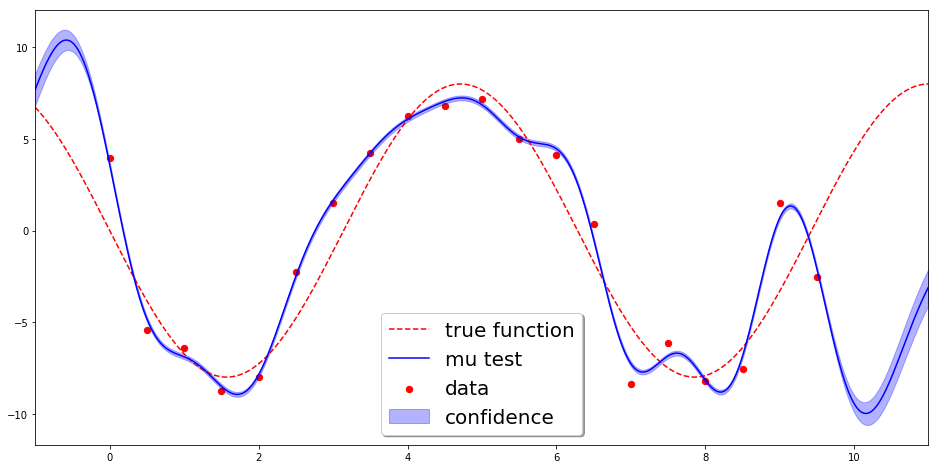

In [9]:
plot_result()

Посмотрим как ведёт себя регрессия для разных значений $\beta$

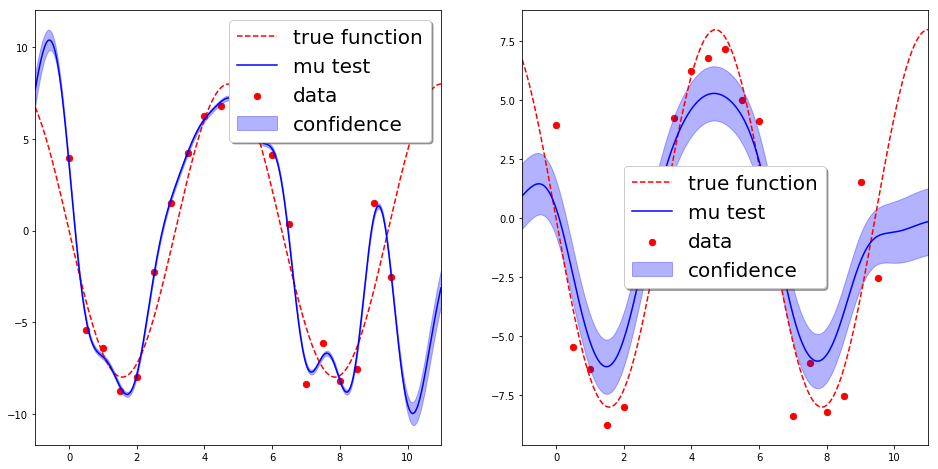

In [10]:
plt.subplot(121)
theta = np.array([1.0])
beta = 100.0
kernel = rbf_k
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)
plot_result()
plt.subplot(122)
theta = np.array([1.0])
beta = 1.0
kernel = rbf_k
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)
plot_result()

Запишите что вы пронаблюдали и как можно интерпретировать параметр $\beta$.  
(_пункт не оценивается_)

beta очень похожа на априорное распределение точности $\dfrac{1}{\sigma^2}$. 

### Линейная ковариационная функция

In [11]:
theta = np.array([1.0])
beta = 100.0
kernel = linear_k
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)

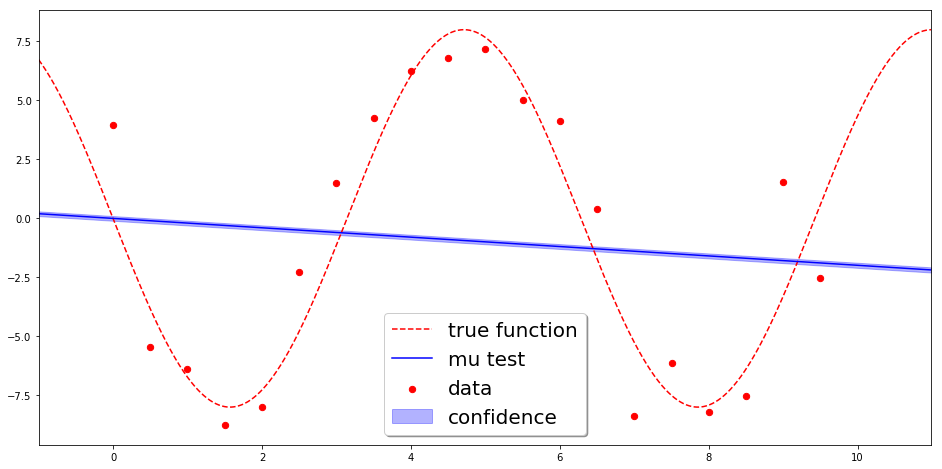

In [12]:
plot_result()

### Ковариационная функция Орнштейна-Уленбека

In [13]:
theta = np.array([1.0])
beta = 100.0
kernel = ou_k
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)

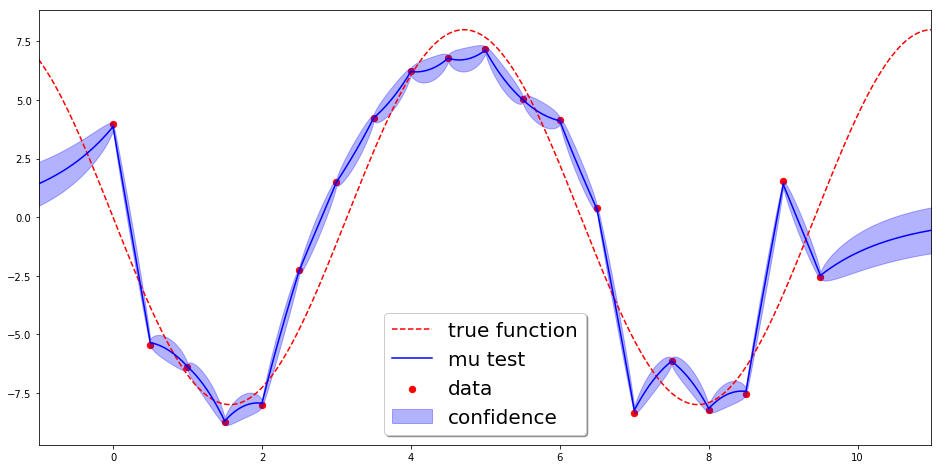

In [14]:
plot_result()

На практике часто прибегают к смеси ковариационных функций, чтобы добиться определённых свойств регрессии.

In [15]:
theta = np.array([1.0])
beta = 10.0
kernel = lambda X,Y,theta: ou_k(X,Y,theta) + rbf_k(X,Y,theta)
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)

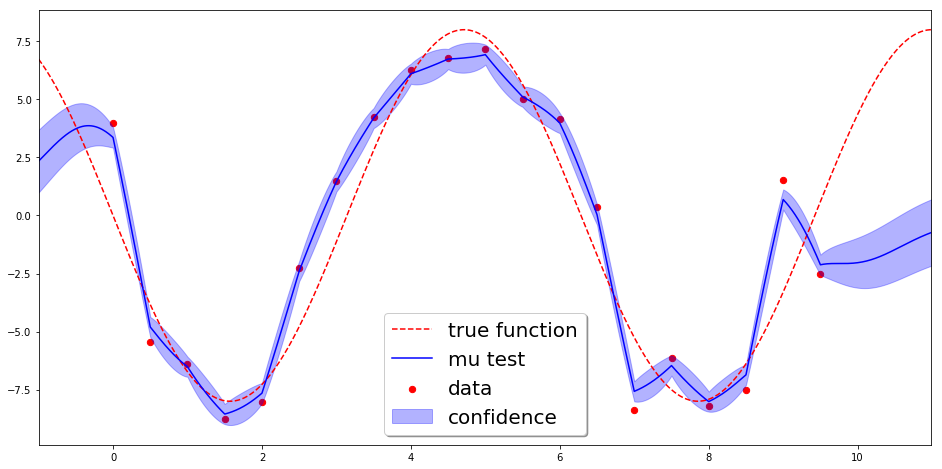

In [16]:
plot_result()

### Подбор параметров

Подбор параметров $\theta$ для произвольного ядра можно сделать максимизируя правдоподобие на обучающей выборке:

$$\log p(\mathbf{t}|\theta) = -\frac{1}{2}\log|C_N| - \frac{1}{2}\mathbf{t}^TC_N^{-1}\mathbf{t} - \frac{N}{2}\log(2\pi) \to \max_{\theta}.$$

Максимизировать заданный функционал мы будем с помощью градиентного подъёма, для чего нам понадобится формула для градиента по $\theta$:

$$\frac{\partial}{\partial \theta_j}\log p(\mathbf{t}|\theta) = -\frac{1}{2}\text{Tr}\bigg(C_N^{-1}\frac{\partial C_N}{\partial \theta_j}\bigg) + \frac{1}{2}\mathbf{t}^TC_N^{-1}\frac{\partial C_N}{\partial \theta_j}C_N^{-1}\mathbf{t}$$

**2.** Реализуйте функцию для расчёта градиента логарифма правдоподобия по логарифму $\theta$, а также функцию для расчёта правдоподобия. Ядро – RBF.

In [17]:
def get_rbf_grad_log_theta(X, Y, theta, beta):
    K = rbf_k(X, X, theta)
    C_N_inv = np.linalg.inv(K + np.eye(X.shape[0]) / beta)
    temp_0 = - (X[:,None,:] - Y[None,:,:]) ** 2 * theta[None, None,:]
    grad_C = temp_0 * np.exp(temp_0) 
    temp_1 = np.einsum('ij,jkl->ikl', C_N_inv, grad_C)
    temp_2 = np.einsum('ijk,jl->ilk', temp_1, C_N_inv)
    return -0.5 * temp_1.diagonal().sum(axis=1) + 0.5 * np.einsum('i,ijk,j->k', Y.flatten(), temp_2, Y.flatten())

def get_likelihood(X, Y, theta, beta):
    K = rbf_k(X, X, theta)
    C_N = K + np.eye(X.shape[0]) / beta
    return -0.5 * np.log(np.linalg.det(C_N)) - 0.5 * Y.T @ np.linalg.inv(C_N) @ Y - X.shape[0] / 2 * np.log(2 * np.pi)

In [18]:
lr = 1e-3
num_iterations = 100
beta = 100.0
log_theta = np.log(np.array([10.0]))
likelihood = []
theta_history = []
for _ in range(num_iterations):
    theta_history.append(np.exp(log_theta))
    log_theta = log_theta + lr*get_rbf_grad_log_theta(X_train, T_train, np.exp(log_theta), beta)
    likelihood.append(get_likelihood(X_train, T_train, np.exp(log_theta), beta))
likelihood = np.array(likelihood).flatten()
theta_history = np.array(theta_history).flatten()

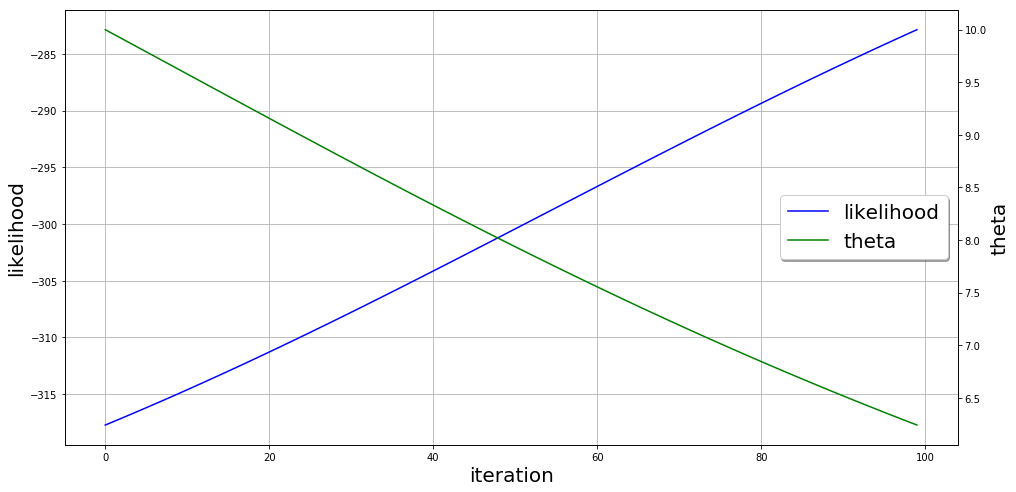

In [19]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(likelihood, label='likelihood', c='b')
ax1.set_xlabel('iteration', fontsize=20)
ax1.set_ylabel('likelihood', fontsize=20)
ax1.grid()

ax2.plot(theta_history, label='theta', c='g')
ax2.set_ylabel('theta', fontsize=20)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, fontsize=20, loc='center right', frameon=True, shadow=True)
plt.show()

In [20]:
beta = 100.0
kernel = rbf_k
mu_test, sigma_test = predict(X_train, T_train, X_test, np.exp(log_theta), beta, kernel)

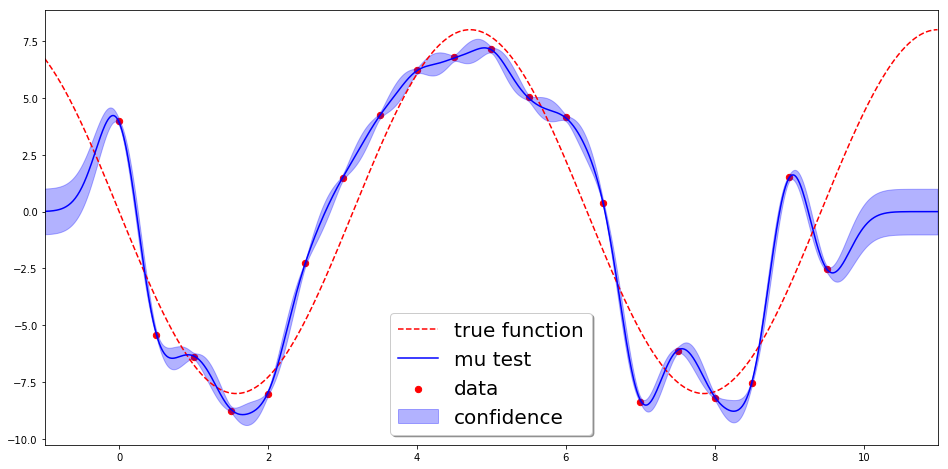

In [21]:
plot_result()

Сравните этот график с графиком для $\theta=1$. Что произошло с мат. ожиданием? Как изменился параметр $\theta$?  
(_пункт не оценивается_)

In [26]:
beta = 100.0
kernel = rbf_k
mu_test, sigma_test = predict(X_train, T_train, X_test, np.ones(X_train.shape[1]), beta, kernel)

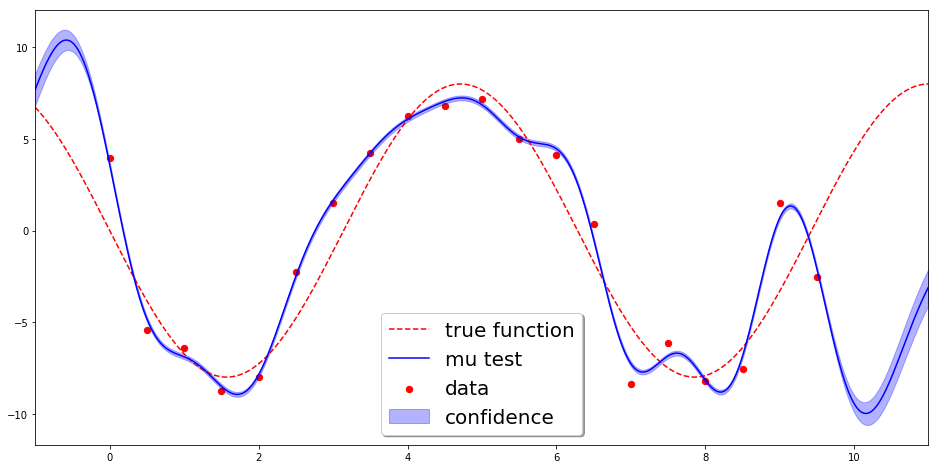

In [27]:
plot_result()

In [28]:
np.exp(log_theta)

array([ 6.21059206])

Параметр $\theta$ вырос, есть ощущение, что после подбора параметра мат. ожидание приблизилось к точкам обучающей выборки. Но не думаю, что это однозначный плюс.

## Оптимизация с помощью Гауссовского процесса

С помощью Гауссовского процесса можно решать задачи black-box оптимизации. То есть, оптимизировать функцию, вид которой нам не известен и нет никакой дополнительной информации, кроме её значений в некоторых точках. Такой метод оптимизации может использоваться для поиска экстремумов некоторой функции, которую очень дорого вычислять, а градиенты этой функции мы и вовсе не можем рассчитать.

Концепция такого алгоритма оптимизации следующая:
1. Настраиваем параметры Гауссовского процесса для имеющегося набора точек.
2. В каждой точке пространства $x$ мы можем посчитать величину expected improvement:
$$\text{EI}(x) = \mathbb{E}_{y(x)}\max(0,t_{\min} - y(x)),$$
где $t_{\min}$ – минимальное значение целевой переменной на уже имеющейся выборке.  
На практике же, мы не можем посчитать expected improvement в каждой точке пространства, но мы можем оптимизировать эту функцию относительно $x$ методами первого или второго порядка и найти локальный максимум этой функции.
3. В качестве новой точки выбираем $x^* = \text{argmax}\; \text{EI}(x)$ и рассчитываем значение $t^*$ в этой точке. После чего добавляем эту точку к нашим данным и возвращаемся к шагу 1.

Сгенерируем выборку

In [22]:
def f(x):
    return -1/np.sqrt(2*np.pi*0.25)*np.exp(-0.5/0.09*(x-4)**2)-1/np.sqrt(2*np.pi*1.0)*np.exp(-0.5/1.0*(x-8)**2)

support = np.arange(0.95,11.1,1e-2)

In [23]:
X_train = np.arange(2.0,10.0,3.0)
X_train = X_train + (2.*np.random.rand(len(X_train))-1.)
X_train = X_train.reshape([len(X_train), -1])
Y_train = f(X_train)
T_train = Y_train

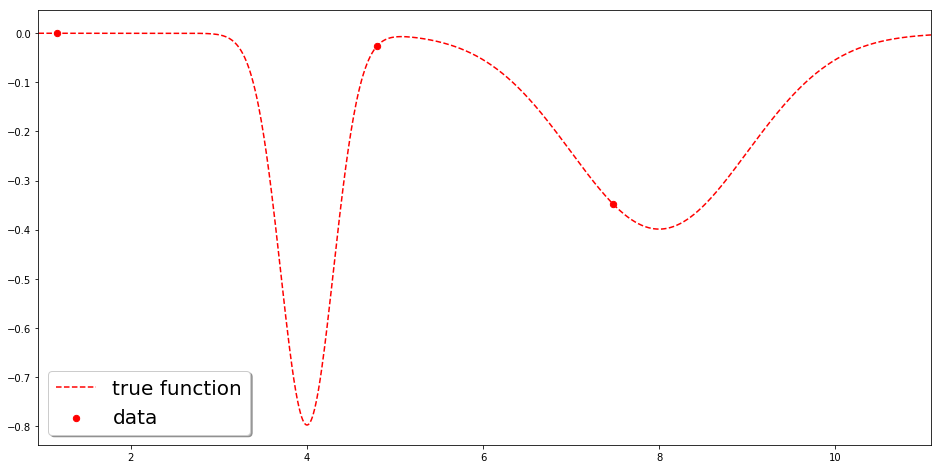

In [24]:
figsize(16,8)
plt.scatter(X_train.flatten(), T_train.flatten(), label='data', c='r', s=40)
plt.plot(support, f(support), '--r', label='true function')
plt.legend(fontsize=20, frameon=True, shadow=True)
plt.xlim(np.min(support), np.max(support))
plt.show()

**3. ** Выведите формулу для expected improvement.

Вспомним нашу модель:
$$t_i = f(x_i)+\varepsilon_i, \; \varepsilon_i \sim \mathcal{N}(0,\sqrt{2})$$
$$\hat{y}(x) \sim \mathcal{N}(\mu(x),\sigma^2(x))$$
$$\mu(x) = \mathbf{k}^T(x)C_N^{-1}\mathbf{t}, \;\;\;\; \sigma^2(x) = k(x,x)+\beta^{-1}-\mathbf{k}^T(x)C_N^{-1}\mathbf{k}(x),$$

где $\mathbf{k} = k(x_i, x)$ – вектор, состоящий из элементов $k(x_i, x), \; i=1,\ldots,N$,  
$\mathbf{t} = (t_1,\ldots,t_N)$ – вектор ответов на обучающей выборке,  
$С_N = \mathbf{K} + \beta^{-1}E$, где $\mathbf{K}_{ij} = k(x_i,x_j)$ – ковариационная матрица.

Распишем подробнее expected improvement:
$$\text{EI}(x) = \mathbb{E}_{y(x)}\max(0,t_{\min} - y(x))=$$
$$=\mathbb{E}_{y(x)}(t_{\min} + \max(-t_{\min}, - y(x)))=\mathbb{E}_{y(x)}(t_{\min} - \min(t_{\min}, y(x)))=$$
$$=t_{\min}-\mathbb{E}_{y(x)}\min(t_{\min}, y(x))$$

Теперь распишем мат. ожидание:
$$\mathbb{E}_{y(x)}\min(t_{\min}, y(x))=\int_{-\infty}^{\infty}\min(t_{\min},y)p(y|x,\theta)dy=$$
$$=\int_{-\infty}^{t_{\min}}yp(y|x,\theta)dy + \int_{t_{\min}}^{\infty}t_{\min}p(y|x,\theta)dy$$

$$\int_{t_{\min}}^{\infty}t_{\min}p(y|x,\theta)dy=t_{\min}-t_{\min}F_x(t_{\min}),$$
где $F_x(y)$ - функция распределения нормального распределения.

$$\int_{-\infty}^{t_{\min}}yp(y|x,\theta)dy=\frac{1}{\sigma(x)\sqrt{2\pi}}\int_{-\infty}^{t_{\min}}y\ \exp(-\frac{(y-\mu(x))^2}{2\sigma^2(x)})dy=$$
$$=\frac{1}{\sigma(x)\sqrt{2\pi}}\int_{-\infty}^{t_{\min}}(y-\mu(x))\ \exp(-\frac{(y-\mu(x))^2}{2\sigma^2(x)})d(y-\mu(x)) + \mu(x)F_x(t_{\min})=$$
$$=\mu(x)F_x(t_{\min})-\frac{\sigma(x)}{\sqrt{2\pi}}\exp(-\frac{t_{\min}^2}{2\sigma^2(x)}).$$
Такие образом:
$$\text{EI}(x)=t_{\min}-(t_{\min}-t_{\min}F_x(t_{\min})+\mu(x)F_x(t_{\min})-\frac{\sigma(x)}{\sqrt{2\pi}}\exp(-\frac{t_{\min}^2}{2\sigma^2(x)}))=$$
$$=F_x(t_{\min})(t_{\min}-\mu(x))+\frac{\sigma(x)}{\sqrt{2\pi}}\exp(-\frac{t_{\min}^2}{2\sigma^2(x)})$$

**4. ** Реализуйте функцию для расчёта expected improvement.

In [25]:
from scipy import stats

def get_expected_improvement(X_train, T_train, X_test, theta, beta, kernel):
    mu, sigma = predict(X_train, T_train, X_test, theta, beta, kernel)
    t = np.min(T_train)
    return stats.norm.cdf(t, mu, sigma) * (t - mu) + sigma / np.sqrt(2 * np.pi) * np.exp(-t ** 2 / 2 / sigma ** 2)

In [26]:
X_test = support
X_test = X_test.reshape([len(X_test), -1])

In [27]:
def plot_expected_improvement(X_train, T_train, expected_improvement, predictions):
    fig, ax1 = plt.subplots(1,1)
    ax2 = ax1.twinx()

    ax1.scatter(X_train.flatten(), T_train.flatten(), label='data', c='r', s=40)
    ax1.plot(support, predictions, label='mean')
    ax1.plot(support, f(support), '--r', label='true function')
    ax1.grid()

    ax2.plot(support, expected_improvement, label='Expected improvement', c='g')
    ax2.scatter(support[np.argmax(expected_improvement)], np.max(expected_improvement), label='max', c='g', s=40)
    ax2.set_ylabel('Expected improvement', fontsize=20)

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, fontsize=10, frameon=True, shadow=True)
    plt.xlim(np.min(support), np.max(support))

In [28]:
import time
from IPython import display

Запустите процесс оптимизации. Сошёлся ли он в точку минимума? Попробуйте разные значения параметров.  
(_пункт не оценивается_)

Ну, после большинства запусков остается ощущение, что до сходимости не хватило несколько итераций. При уменьшении beta чаще скатывается в локальный минимум.

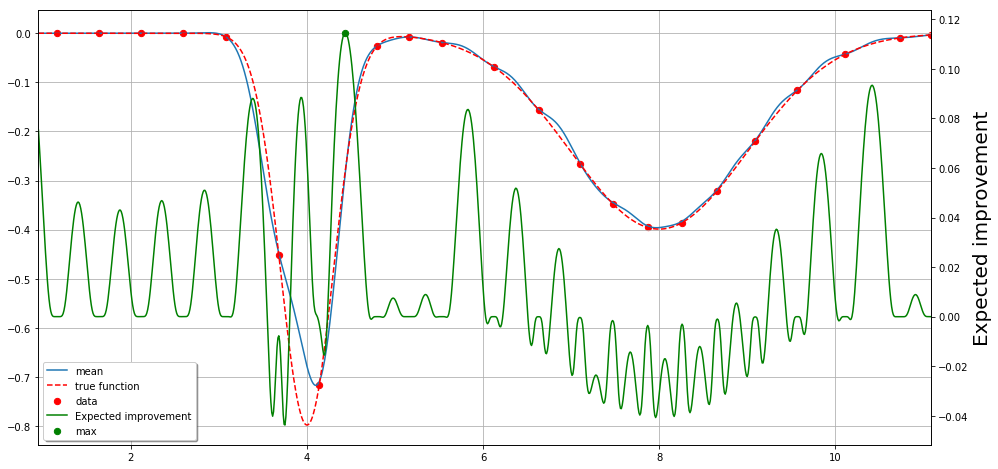

In [29]:
log_theta = np.log(np.array([10.0]))
beta = 100.0
num_tuning_steps = 200
num_new_points = 20
lr = 1e-3
for _ in range(num_new_points):
    log_theta = np.log(np.array([10.0]))
    plt.clf()
    # model tuning  
    for _ in range(num_tuning_steps):
        grad = get_rbf_grad_log_theta(X_train, T_train, np.exp(log_theta), beta)
        log_theta = log_theta + lr*grad
    # calculating expected improvement for all points
    expected_improvement = get_expected_improvement(X_train, T_train, X_test, np.exp(log_theta), beta, kernel)
    mu, sigma = predict(X_train, T_train, X_test, np.exp(log_theta), beta, kernel)
    plot_expected_improvement(X_train, T_train, expected_improvement, mu)
    # adding new point
    X_train = np.vstack([X_train, np.array(support[np.argmax(expected_improvement)])])
    T_train = f(X_train)
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1.0)
    
_ = plt.clf()